# Starbucks Capstone Challenge

## Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

## Import packages and functions

In [405]:
import pandas as pd
import numpy as np
import math
import json
from datetime import datetime, timedelta

import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

# ML pkgs
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn import metrics
from sklearn.metrics import classification_report,roc_auc_score,roc_curve,precision_recall_curve

import shap

pd.set_option('display.max_columns', None)

#--enable interative widgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [16]:
'''
Function to check missing value
arg: 
    df - table
    source - table name
'''

def data_quality_stats(df,source=None):
    '''
    
    '''
    res_columns = ['Source','Feature','DataType','Missing Values','Missing Value %', 'Unique Values']
    res_df = pd.DataFrame(columns=res_columns)
    
    for column_name in list(df):
        null_count = df[column_name].isnull().sum()
        sparcity = str(round(null_count*100/len(df),2))
        n_unique = df[column_name].nunique()
        data_type = df[column_name].dtype
        
        row = [source,column_name,data_type,null_count,sparcity,n_unique]
        
        res_df = res_df.append(pd.Series(row,index=res_columns),ignore_index=True).sort_values('Missing Values',ascending=False)
    
    return res_df

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Cleaning

## 1. Portfolio - key findings
- only 9 offers in total
- offer type consists of bogo, informational, and discounts
- transformation on channels column is needed
- There are no missing values

In [29]:
df_portfolio = pd.concat([portfolio,pd.get_dummies(portfolio['channels'].apply(pd.Series).stack()).sum(level=0)],axis=1).drop(columns='channels',axis=1)
df_portfolio

,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


In [30]:
data_quality_stats(df_portfolio,source="Portfolio")

,Source,Feature,DataType,Missing Values,Missing Value %,Unique Values
0,Portfolio,reward,int64,0,0.0,5
1,Portfolio,difficulty,int64,0,0.0,5
2,Portfolio,duration,int64,0,0.0,5
3,Portfolio,offer_type,object,0,0.0,3
4,Portfolio,id,object,0,0.0,10
5,Portfolio,email,uint8,0,0.0,1
6,Portfolio,mobile,uint8,0,0.0,2
7,Portfolio,social,uint8,0,0.0,2
8,Portfolio,web,uint8,0,0.0,2


## 2. Profile - key findings
- No duplicates for customer ID in profile data
- 12.79% data are missing in terms of gender and income
- became_member_on should be a date field needs to be cleaned
- 2,175 customers are aged 118, these records miss income and gender too
- For gender, 6,129 are females, 8,484 are males, and 212 are O
- Income median is 64k, with a max of 120k and minimum of 30k
- Create a coloum for customer staying length, the median of customer staying length is 1788 days (appox 5 years), max staying 3253 days (almost 9 years), minimun is 1430 days (4 years)
- Create buckets for age, income and staying length column

In [32]:
data_quality_stats(profile,source="Profile")

,Source,Feature,DataType,Missing Values,Missing Value %,Unique Values
0,Profile,gender,object,2175,12.79,3
4,Profile,income,float64,2175,12.79,91
1,Profile,age,int64,0,0.0,85
2,Profile,id,object,0,0.0,17000
3,Profile,became_member_on,int64,0,0.0,1716


In [35]:
df_profile = profile.copy()

In [36]:
#convert became_member_on to be date column
df_profile['became_member_on'] = pd.to_datetime(df_profile['became_member_on'], format='%Y%m%d')

Customer Age distribution <Br>
    There are 2175 people whose age are 118, and these are the ones that miss income and gender too, so should be removed
   

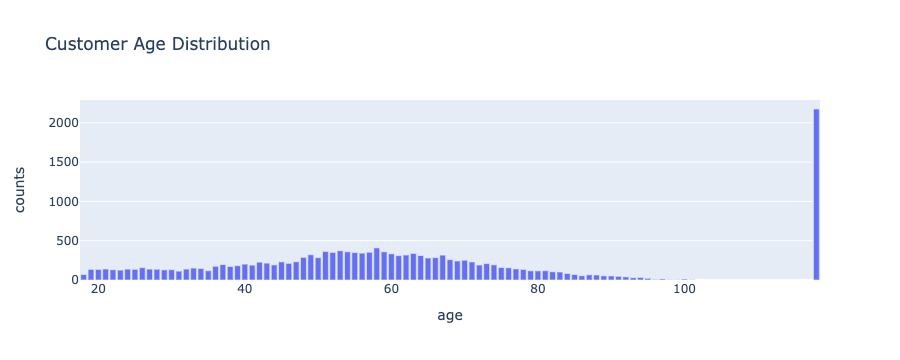

In [47]:
fig = px.bar(df_profile.groupby('age').size().to_frame('counts').reset_index(), x='age', y='counts', 
             title="Customer Age Distribution")
fig.show()

In [48]:
data_quality_stats(profile[profile['age']==118],source="Profile")

,Source,Feature,DataType,Missing Values,Missing Value %,Unique Values
0,Profile,gender,object,2175,100.0,0
4,Profile,income,float64,2175,100.0,0
1,Profile,age,int64,0,0.0,1
2,Profile,id,object,0,0.0,2175
3,Profile,became_member_on,int64,0,0.0,950


Customer Gender distribution <br>
6,129 are females, 8,484 are males, and 212 are O

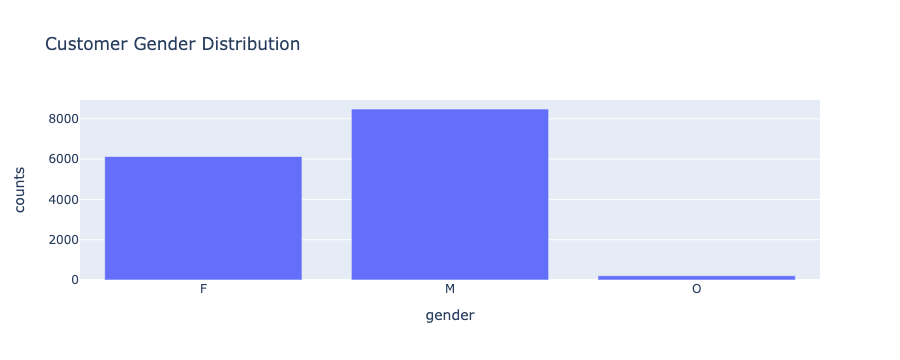

In [50]:
fig = px.bar(df_profile.groupby('gender').size().to_frame('counts').reset_index(), x='gender', y='counts', 
             title="Customer Gender Distribution")
fig.show()

Customer Income distribution <br>
Income median is 64k, with a max of 120k and minimum of 30k

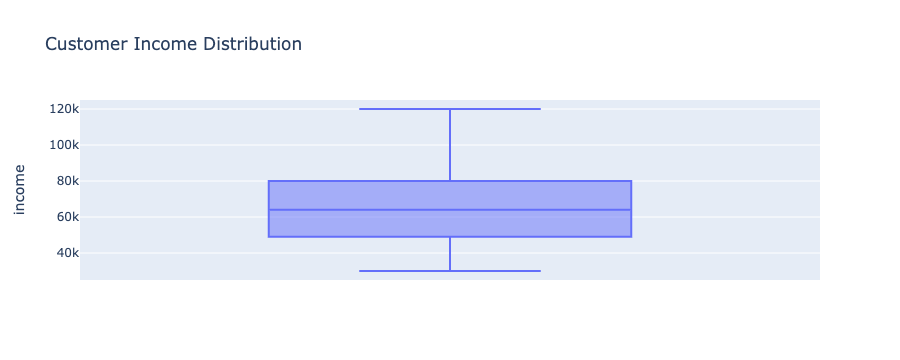

In [55]:
fig = px.box(df_profile, y="income", title="Customer Income Distribution")
fig.show()

Customer staying length distribution <br>
The median of customer staying length is 1788 days (appox 5 years), max staying 3253 days (almost 9 years), minimun is 1430 days (4 years)

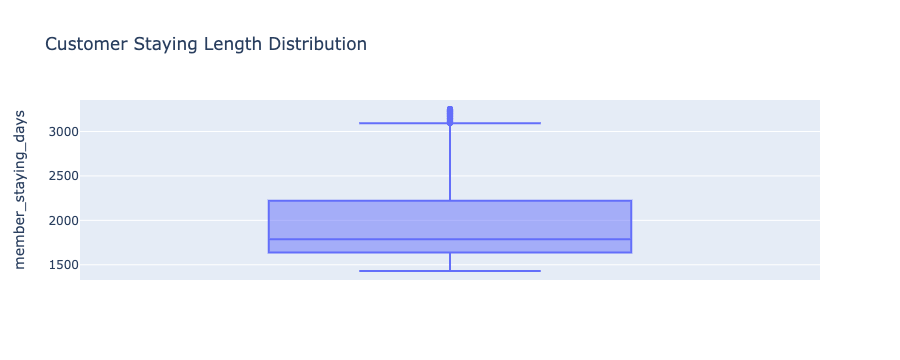

In [74]:
df_profile['member_staying_days'] = (datetime.today() - df_profile['became_member_on']).astype('timedelta64[D]')
fig = px.box(df_profile, y="member_staying_days", title="Customer Staying Length Distribution")
fig.show()

In [164]:
df_profile = df_profile[df_profile['age']!=118]

df_profile['age_band'] = np.select(
    [
        (df_profile['age']>=18) & (df_profile['age']<=24), 
        (df_profile['age']>=25) & (df_profile['age']<=44), 
        (df_profile['age']>=45) & (df_profile['age']<=59),
        (df_profile['age']>=60)
    ], 
    [
        'AgeBand18-24', 
        'AgeBand25-44',
        'AgeBand45-59', 
        'AgeBand60Plus',
    ], 
    default='Unknown'
)

df_profile['income_band'] = np.select(
    [
        (df_profile['income']>=30000) & (df_profile['income']<49000), 
        (df_profile['income']>=49000) & (df_profile['income']<64000), 
        (df_profile['income']>=64000) & (df_profile['income']<=80000),
        (df_profile['income']>=80000)
    ], 
    [
        'income-lower-than-average', 
        'income-average',
        'income-above-average', 
        'income-high',
    ], 
    default='Unknown'
)

df_profile['member_type'] = np.select(
    [
        (df_profile['member_staying_days']<1638), 
        (df_profile['member_staying_days']>=1638) & (df_profile['member_staying_days']<2221), 
        (df_profile['member_staying_days']>=2221)
    ], 
    [
        'New', 
        'Average',
        'Loyal'
    ], 
    default='Unknown'
)

df_profile

,gender,age,id,became_member_on,income,member_staying_days,age_band,income_band,member_type
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1806.0,AgeBand45-59,income-high,Average
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1873.0,AgeBand60Plus,income-high,Average
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,1521.0,AgeBand60Plus,income-above-average,New
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,1597.0,AgeBand60Plus,income-average,New
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,1687.0,AgeBand45-59,income-average,Average
...,...,...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,1482.0,AgeBand45-59,income-average,New
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,1443.0,AgeBand60Plus,income-above-average,New
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,1976.0,AgeBand45-59,income-above-average,Average
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,2301.0,AgeBand60Plus,income-average,Loyal


## 3. Transcript - key findings
- values column consist of dictionaries, key is offer id and amount, dictionary can be converted into columns
- there are three types of events: offer recieved, offer viewed, and offer completed
- time column represents for hours, can be transformed to days so align with profile data

In [141]:
df_transcript = transcript.copy()

In [142]:
df_transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [143]:
# get values out of value column and convert them into offer_id and trans_amount columns
df_transcript['offer_id'] = [[*i.values()][0] if [*i.keys()][0] in ['offer id'] else None for i in transcript.value]
df_transcript['trans_amount'] = [[*i.values()][0] if [*i.keys()][0] in ['amount'] else None for i in transcript.value]

df_transcript = df_transcript.drop(columns='value',axis=1).sort_values(["person","time"])

# transform time from hours to days
df_transcript['time'] = df_transcript['time'] /24

#offer completed is not assigned with an offer id, but we know it's the same as the offer that people completed previously
df_transcript['offer_id'] = np.where(df_transcript['event']=='offer completed',df_transcript['offer_id'].shift(2),df['offer_id'])

In [144]:
# pick out one person and check his transactions
df_transcript[df_transcript['person'].str.contains('ffff82501cea40309d5fdd7edcca4a07')]

,person,event,time,offer_id,trans_amount
1393,ffff82501cea40309d5fdd7edcca4a07,offer received,0.00,fafdcd668e3743c1bb461111dcafc2a4,NaN
15836,ffff82501cea40309d5fdd7edcca4a07,offer viewed,0.25,fafdcd668e3743c1bb461111dcafc2a4,NaN
32762,ffff82501cea40309d5fdd7edcca4a07,transaction,2.50,None,16.06
32763,ffff82501cea40309d5fdd7edcca4a07,offer completed,2.50,fafdcd668e3743c1bb461111dcafc2a4,NaN
37060,ffff82501cea40309d5fdd7edcca4a07,transaction,3.25,None,7.18
45575,ffff82501cea40309d5fdd7edcca4a07,transaction,5.00,None,9.12
54574,ffff82501cea40309d5fdd7edcca4a07,offer received,7.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
69626,ffff82501cea40309d5fdd7edcca4a07,offer viewed,7.25,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
79667,ffff82501cea40309d5fdd7edcca4a07,transaction,8.25,None,22.88
79668,ffff82501cea40309d5fdd7edcca4a07,offer completed,8.25,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


## 4. Merge Data

In [170]:
df = pd.merge(df_transcript,df_portfolio,left_on="offer_id",right_on="id",how="left")
df = pd.merge(df,df_profile,left_on="person",right_on="id",how="left").drop(columns=['id_x','id_y'],axis=1)

In [240]:
df[df['person'].str.contains('78afa995795e4d85b5d9ceeca43f5fef')]

,person,event,time,offer_id,trans_amount,reward,difficulty,duration,offer_type,email,mobile,social,web,gender,age,became_member_on,income,member_staying_days,age_band,income_band,member_type
143532,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,F,75.0,2017-05-09,100000.0,1873.0,AgeBand60Plus,income-high,Average
143533,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,0.25,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,F,75.0,2017-05-09,100000.0,1873.0,AgeBand60Plus,income-high,Average
143534,78afa995795e4d85b5d9ceeca43f5fef,transaction,5.50,None,19.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,75.0,2017-05-09,100000.0,1873.0,AgeBand60Plus,income-high,Average
143535,78afa995795e4d85b5d9ceeca43f5fef,offer completed,5.50,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,F,75.0,2017-05-09,100000.0,1873.0,AgeBand60Plus,income-high,Average
143536,78afa995795e4d85b5d9ceeca43f5fef,transaction,6.00,None,17.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,75.0,2017-05-09,100000.0,1873.0,AgeBand60Plus,income-high,Average
143537,78afa995795e4d85b5d9ceeca43f5fef,offer received,7.00,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,0.0,3.0,informational,1.0,1.0,1.0,0.0,F,75.0,2017-05-09,100000.0,1873.0,AgeBand60Plus,income-high,Average
143538,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,9.00,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,0.0,3.0,informational,1.0,1.0,1.0,0.0,F,75.0,2017-05-09,100000.0,1873.0,AgeBand60Plus,income-high,Average
143539,78afa995795e4d85b5d9ceeca43f5fef,transaction,9.25,None,19.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,75.0,2017-05-09,100000.0,1873.0,AgeBand60Plus,income-high,Average
143540,78afa995795e4d85b5d9ceeca43f5fef,transaction,10.00,None,29.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,75.0,2017-05-09,100000.0,1873.0,AgeBand60Plus,income-high,Average
143541,78afa995795e4d85b5d9ceeca43f5fef,transaction,15.75,None,23.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,75.0,2017-05-09,100000.0,1873.0,AgeBand60Plus,income-high,Average


# Exploratary Data Analysis

## 1. Which offer are most popular?
BOGO is most recieved, and completed by customers, discount offer is most viewed by customers

In [172]:
# The BOGO offer is recieved most by the customers
df[df['event']=='offer received'].groupby(['offer_id','offer_type']).size().to_frame('count').reset_index().sort_values("count",ascending=False)

,offer_id,offer_type,count
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,7677
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,7668
7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,7658
1,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7646
2,2906b810c7d4411798c6938adc9daaa5,discount,7632
5,5a8bc65990b245e5a138643cd4eb9837,informational,7618
3,3f207df678b143eea3cee63160fa8bed,informational,7617
9,fafdcd668e3743c1bb461111dcafc2a4,discount,7597
4,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,7593
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,7571


In [173]:
# The discount offer is viewed most by the customers, followed by BOGO
df[df['event']=='offer viewed'].groupby(['offer_id','offer_type']).size().to_frame('count').reset_index().sort_values("count",ascending=False)

,offer_id,offer_type,count
1,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7337
9,fafdcd668e3743c1bb461111dcafc2a4,discount,7327
4,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,7298
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,7264
7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,6716
5,5a8bc65990b245e5a138643cd4eb9837,informational,6687
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,4171
3,3f207df678b143eea3cee63160fa8bed,informational,4144
2,2906b810c7d4411798c6938adc9daaa5,discount,4118
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,2663


In [174]:
# The BOGO offer is completed most by the customers, followed by discounts
df[df['event']=='offer completed'].groupby(['offer_id','offer_type']).size().to_frame('count').reset_index().sort_values("count",ascending=False)

,offer_id,offer_type,count
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,3634
1,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3621
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,3470
9,fafdcd668e3743c1bb461111dcafc2a4,discount,3230
7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,3000
4,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,2872
2,2906b810c7d4411798c6938adc9daaa5,discount,2816
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,1527
3,3f207df678b143eea3cee63160fa8bed,informational,422
5,5a8bc65990b245e5a138643cd4eb9837,informational,408


## 2. Who are mostly likely to complete an offer?
- Men will complete more offers compared with women, but it seems that women are more likely to compare 5-6 offers compared than men.
- High income people complete more offers than other income level.
- The older people is, the more likely they finish an offer.
- People who are quite new to Starbucks are less likely to finish an offer.

In [177]:
df_agg = df[df['event']=='offer completed'].groupby(['person','gender','age','member_staying_days','income','age_band','income_band','member_type']).size().to_frame("offer_completed_count").reset_index().sort_values("offer_completed_count",ascending=False)
df_agg

,person,gender,age,member_staying_days,income,age_band,income_band,member_type,offer_completed_count
11985,ffff82501cea40309d5fdd7edcca4a07,F,45.0,2038.0,62000.0,AgeBand45-59,income-average,Average,6
5773,7ba2327c339f4081b2a94293df048b4d,M,49.0,2057.0,66000.0,AgeBand45-59,income-above-average,Average,6
3499,4a8ee6675cbf4929833a61b6f0e5c539,F,51.0,1900.0,88000.0,AgeBand45-59,income-high,Average,6
5243,7055b5fa5f8647618aa14e220b7c6b5c,M,44.0,2041.0,47000.0,AgeBand25-44,income-lower-than-average,Average,6
1506,2193267a91d747dfa7197bb39c78b2e5,M,63.0,1931.0,86000.0,AgeBand60Plus,income-high,Average,6
...,...,...,...,...,...,...,...,...,...
6921,93907d06a946424ba630487fe7aeafd1,F,67.0,1497.0,71000.0,AgeBand60Plus,income-above-average,New,1
6919,938d98afcb894aeb8db9c60fca96ec58,M,32.0,1613.0,48000.0,AgeBand25-44,income-lower-than-average,New,1
9592,ccfc5113eb5045639709024000f346ab,M,90.0,1794.0,72000.0,AgeBand60Plus,income-above-average,Average,1
3743,4fbb451301b54298a24590359c56c93b,M,74.0,1666.0,67000.0,AgeBand60Plus,income-above-average,Average,1


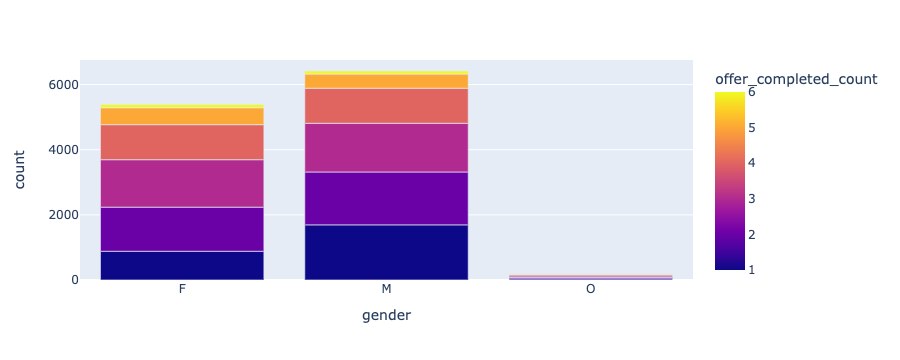

In [183]:
fig = px.bar(df_agg.groupby(['offer_completed_count','gender'])['offer_completed_count'].size().to_frame('count').reset_index(),
             x="gender", y="count", color="offer_completed_count")
fig.show()

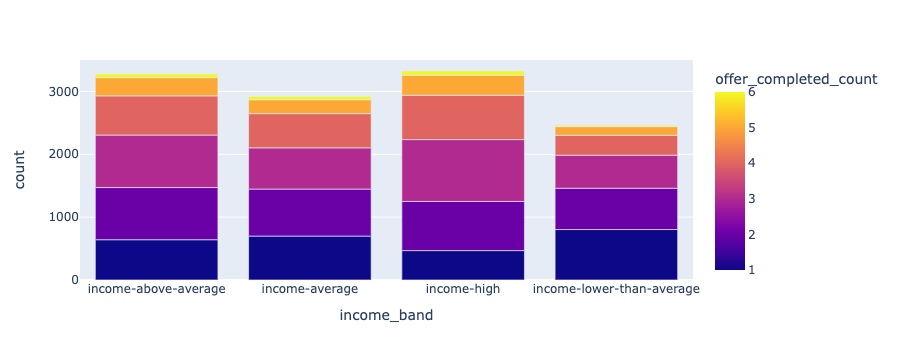

In [182]:
fig = px.bar(df_agg.groupby(['offer_completed_count','income_band'])['offer_completed_count'].size().to_frame('count').reset_index(),
             x="income_band", y="count", color="offer_completed_count")
fig.show()

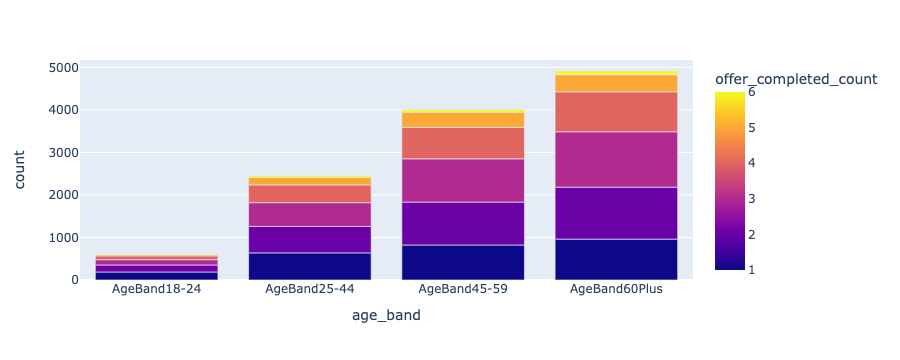

In [184]:
fig = px.bar(df_agg.groupby(['offer_completed_count','age_band'])['offer_completed_count'].size().to_frame('count').reset_index(),
             x="age_band", y="count", color="offer_completed_count")
fig.show()

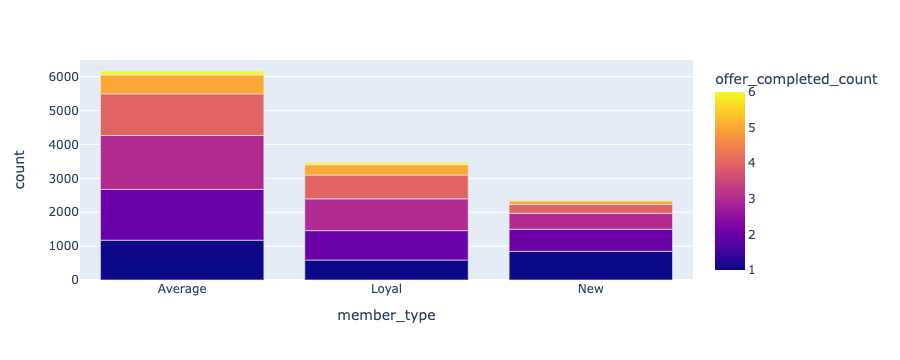

In [185]:
fig = px.bar(df_agg.groupby(['offer_completed_count','member_type'])['offer_completed_count'].size().to_frame('count').reset_index(),
             x="member_type", y="count", color="offer_completed_count")
fig.show()

# Model - predicts whether or not someone will respond to an offer

## 1. Prepare final data

In [255]:
df_final = pd.DataFrame()

for customer_id in df['person'].unique():
# df['person'].unique():
    # extract received, completed, viewed offer data from customer offers
    df_one = df[df['person']==customer_id]
    offer_received_data = df_one[df_one['event'] == 'offer received']
    offer_completed_data = df_one[df_one['event'] == 'offer completed']
    offer_viewed_data = df_one[df_one['event'] == 'offer viewed']
    cust_transaction_data = df_one[df_one['event'] == 'transaction']

    result_one = pd.DataFrame(columns=['offer_id', 'person_id', 'time','total_amount','offer_successful'])

    for idx in range(offer_received_data.shape[0]):
        offer_id = offer_received_data.iloc[idx]['offer_id']
        person_id = offer_received_data.iloc[idx]['person']
        # offer_row = portfolio.loc[portfolio['offer_id'] == offer_id]

        # how long an offer is valid
        duration_days = offer_received_data['duration'].values[0]

        # start and end time of an offer
        start_time = offer_received_data.iloc[idx]['time']
        end_time = start_time + duration_days

        # offers that were completed before they expired
        off_completed_withintime = np.logical_and(
            offer_completed_data['time'] >= start_time, offer_completed_data['time'] <= end_time)

        # offers that were viewed before they expired
        off_viewed_withintime = np.logical_and(
            offer_viewed_data['time'] >= start_time, offer_viewed_data['time'] <=end_time)

        # if offer was both viewed and completed before it expired, it was successful (1)
        offer_successful = off_completed_withintime.sum() > 0 and off_viewed_withintime.sum() > 0

        # transactions before offer expiry
        transaction_withintime = np.logical_and(
            cust_transaction_data['time'] >= start_time, cust_transaction_data['time'] <= end_time)
        transaction_data = cust_transaction_data[transaction_withintime]

        # how much a user spends based on offers
        transaction_total_amount = transaction_data['trans_amount'].sum()

        result_one = result_one.append({'offer_id': offer_id,
                                    'person_id': person_id,
                                    'time': start_time,
                                    'total_amount': transaction_total_amount,
                                    'offer_successful': int(offer_successful),}, ignore_index=True)
    df_final = pd.concat([df_final,result_one],axis=0)

df_final

,offer_id,person_id,time,total_amount,offer_successful
0,5a8bc65990b245e5a138643cd4eb9837,0009655768c64bdeb2e877511632db8f,7.0,22.16,0
1,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f,14.0,0.00,0
2,f19421c1d4aa40978ebb69ca19b0e20d,0009655768c64bdeb2e877511632db8f,17.0,8.57,1
3,fafdcd668e3743c1bb461111dcafc2a4,0009655768c64bdeb2e877511632db8f,21.0,37.94,1
4,2906b810c7d4411798c6938adc9daaa5,0009655768c64bdeb2e877511632db8f,24.0,10.27,0
...,...,...,...,...,...
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,ffff82501cea40309d5fdd7edcca4a07,7.0,111.94,1
2,2906b810c7d4411798c6938adc9daaa5,ffff82501cea40309d5fdd7edcca4a07,14.0,68.31,1
3,2906b810c7d4411798c6938adc9daaa5,ffff82501cea40309d5fdd7edcca4a07,17.0,81.77,1
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,ffff82501cea40309d5fdd7edcca4a07,21.0,51.05,1


In [273]:
# it takes about 30 mins to finish above query, so read csv next time
# df_final.to_csv("data_cleaned_for_model.csv",index=False)
df_final = pd.read_csv("data_cleaned_for_model.csv")

In [274]:
df_final = pd.merge(df_final,df_portfolio,left_on='offer_id',right_on='id',how="inner").drop(columns="id",axis=1)
df_final = pd.merge(df_final,df_profile,left_on='person_id',right_on='id',how="inner").drop(columns="id",axis=1)

In [275]:
df_final['offer_successful'].value_counts()

0    35875
1    30626
Name: offer_successful, dtype: int64

In [299]:
df_final = pd.get_dummies(df_final, columns=['gender','offer_type'])

In [300]:
df_final.head(5)

,offer_id,person_id,time,total_amount,offer_successful,reward,difficulty,duration,email,mobile,social,web,age,became_member_on,income,member_staying_days,age_band,income_band,member_type,gender_F,gender_M,gender_O,offer_type_bogo,offer_type_discount,offer_type_informational
0,5a8bc65990b245e5a138643cd4eb9837,0009655768c64bdeb2e877511632db8f,7.0,22.16,0,0,0,3,1,1,1,0,33,2017-04-21,72000.0,1891.0,AgeBand25-44,income-above-average,Average,0,1,0,0,0,1
1,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f,14.0,0.00,0,0,0,4,1,1,0,1,33,2017-04-21,72000.0,1891.0,AgeBand25-44,income-above-average,Average,0,1,0,0,0,1
2,f19421c1d4aa40978ebb69ca19b0e20d,0009655768c64bdeb2e877511632db8f,17.0,8.57,1,5,5,5,1,1,1,1,33,2017-04-21,72000.0,1891.0,AgeBand25-44,income-above-average,Average,0,1,0,1,0,0
3,fafdcd668e3743c1bb461111dcafc2a4,0009655768c64bdeb2e877511632db8f,21.0,37.94,1,2,10,10,1,1,1,1,33,2017-04-21,72000.0,1891.0,AgeBand25-44,income-above-average,Average,0,1,0,0,1,0
4,2906b810c7d4411798c6938adc9daaa5,0009655768c64bdeb2e877511632db8f,24.0,10.27,0,2,10,7,1,1,0,1,33,2017-04-21,72000.0,1891.0,AgeBand25-44,income-above-average,Average,0,1,0,0,1,0


## 2. Split train/test set

In [331]:
features = df_final.drop(columns=['offer_id', 'person_id','time','total_amount','became_member_on','age_band','income_band','member_type','offer_successful'])
label = df_final[['offer_successful']]

In [332]:
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size = 0.2, random_state=1234)
print('Size of Training set:', x_train.shape[0],'rows and', x_train.shape[1],'columns')
print('Size of Testing set:', x_test.shape[0],'rows and', x_test.shape[1],'columns')

Size of Training set: 53200 rows and 16 columns
Size of Testing set: 13301 rows and 16 columns


In [333]:
features.columns

Index(['reward', 'difficulty', 'duration', 'email', 'mobile', 'social', 'web',
       'age', 'income', 'member_staying_days', 'gender_F', 'gender_M',
       'gender_O', 'offer_type_bogo', 'offer_type_discount',
       'offer_type_informational'],
      dtype='object')

## 3. Building Model

### Compare different ML models

Process is described as:
1. Build model on multiple machine learning algorithms
2. Evaluate performance based on acc,precision,recall,f1,ROC curve,auc
3. To estimate generalisation performance, using 10 fold cv on whole data, and get average accuracy


In [341]:
#input differnt models if you want to test
#ref here: https://scikit-learn.org/stable/supervised_learning.html
model_list = [LogisticRegression(),
              KNeighborsClassifier(),
              DecisionTreeClassifier(),
              RandomForestClassifier(),
              GradientBoostingClassifier(),
              SVC(probability=True),
              GaussianNB()]

In [361]:
def run_model(model_name = model_list):
    
    # Build model on train data
    model = model_name
    model = model.fit(x_train, y_train)
    print("Performance on train dataset:",model.score(x_train, y_train.values.ravel()))
    
    # Predictions/probs on the test dataset
    predicted = pd.DataFrame(model.predict(x_test))
    probs = pd.DataFrame(model.predict_proba(x_test))
    print("Performance on test dataset:",metrics.accuracy_score(y_test, predicted))
    
    #Confusion Matrix
    print("\n Confusion Matrix on test dataset: \n\n",metrics.confusion_matrix(y_test, predicted))
    
    # calculate roc curves
    print("\n ROC curve on test dataset: \n\n")
    ns_probs = [0 for _ in range(len(y_test))]
    model_probs = model.predict_proba(x_test)[:,1]
    ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = metrics.roc_curve(y_test, model_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Model')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Our Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    
    # Let's store all the evaluation metrics
    model_auc = metrics.roc_auc_score(y_test, model_probs)
    model_precision = metrics.precision_score(y_test, predicted, pos_label=1)
    model_recall = metrics.recall_score(y_test, predicted, pos_label=1)
    model_f1 = metrics.f1_score(y_test, predicted, pos_label=1)
    model_cv_scores = np.mean(cross_val_score(model, features, label.values.ravel(), cv=10))
    
    print("AUC score on test dataset:",model_auc)
    print("Precision on test dataset:",model_precision)
    print("Recall on test dataset:",model_recall)
    print("F1 score on test dataset:",model_f1)
    print("10-fold CV score on whole dataset:",model_cv_scores)

#### a. Logistic Regression

/Users/runsangyu/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Performance on train dataset: 0.5281390977443609
Performance on test dataset: 0.5226674686113826

 Confusion Matrix on test dataset: 

 [[4848 2301]
 [4048 2104]]

 ROC curve on test dataset: 




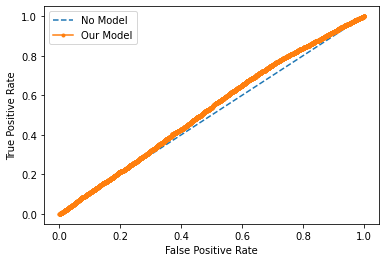

AUC score on test dataset: 0.52658887608932
Precision on test dataset: 0.47763904653802497
Recall on test dataset: 0.3420026007802341
F1 score on test dataset: 0.3985980865776262
10-fold CV score on whole dataset: 0.523480679597053


In [362]:
run_model(model_name = LogisticRegression())

#### b. KNeighbors Classifier

/Users/runsangyu/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Performance on train dataset: 0.7870864661654136
Performance on test dataset: 0.6652131418690324

 Confusion Matrix on test dataset: 

 [[4724 2425]
 [2028 4124]]

 ROC curve on test dataset: 




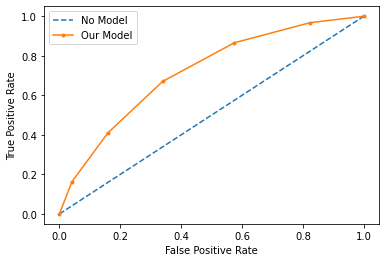

AUC score on test dataset: 0.7169261580684305
Precision on test dataset: 0.6297144602229348
Recall on test dataset: 0.6703511053315995
F1 score on test dataset: 0.649397685221636
10-fold CV score on whole dataset: 0.48797653809761216


In [363]:
run_model(model_name = KNeighborsClassifier())

#### c. Decision Tree Classifier

Performance on train dataset: 0.9671616541353384
Performance on test dataset: 0.6697240808961732

 Confusion Matrix on test dataset: 

 [[5092 2057]
 [2336 3816]]

 ROC curve on test dataset: 




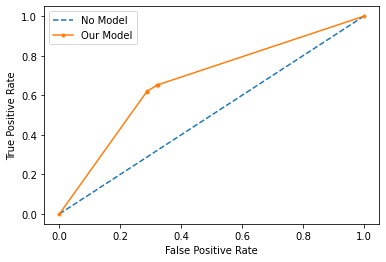

AUC score on test dataset: 0.6712215108790575
Precision on test dataset: 0.6497531074408309
Recall on test dataset: 0.6202860858257477
F1 score on test dataset: 0.6346777546777547
10-fold CV score on whole dataset: 0.5756897860347758


In [364]:
run_model(model_name = DecisionTreeClassifier())

#### d. Random Forest Classifier

<ipython-input-361-72bc57fbf09a>:5: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Performance on train dataset: 0.9671240601503759
Performance on test dataset: 0.7000977370122548

 Confusion Matrix on test dataset: 

 [[5351 1798]
 [2191 3961]]

 ROC curve on test dataset: 




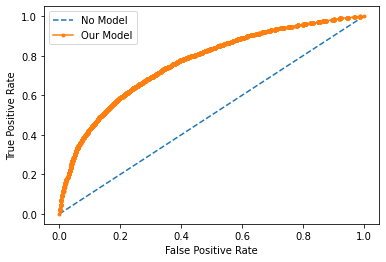

AUC score on test dataset: 0.7648211208711613
Precision on test dataset: 0.6877930196214621
Recall on test dataset: 0.6438556566970091
F1 score on test dataset: 0.665099487868357
10-fold CV score on whole dataset: 0.6620647129777534


In [365]:
run_model(model_name = RandomForestClassifier())

#### e. Gradient Boosting Classifier

/Users/runsangyu/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Performance on train dataset: 0.7243045112781955
Performance on test dataset: 0.7174648522667468

 Confusion Matrix on test dataset: 

 [[5499 1650]
 [2108 4044]]

 ROC curve on test dataset: 




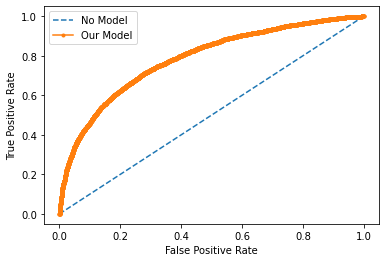

AUC score on test dataset: 0.7852761855623409
Precision on test dataset: 0.7102212855637513
Recall on test dataset: 0.6573472041612484
F1 score on test dataset: 0.6827621137936857
10-fold CV score on whole dataset: 0.7155831278692899


In [366]:
run_model(model_name = GradientBoostingClassifier())

### Hyperparametres Tuning
Gradient Boosting has a comparatively best performance (either on F1 score or 10-fold CV accuracy) and it generalises the model really well compared with other models. So because the model is built using default parametres, let's try to tune the hyperparametres now to see if we can get a better GB model.

In [378]:
gbm = GradientBoostingClassifier(random_state=123)
gbm_default = gbm.fit(x_train, y_train.values.ravel())
gbm_default_cv_scores = np.mean(cross_val_score(gbm_default, features, label.values.ravel(), cv=10))

In [379]:
# Let's first check what's the paramtres in use now:
print('Parameters currently in use:\n')
print( gbm_default.get_params())

Parameters currently in use:

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 123, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


#### Random Search - Try a few combinantions, but cannot beat gbm default model

In [401]:
# Initialise some hyperparametres numbers
n_estimators = [int(x) for x in np.linspace(80, 120, num = 30)] # Number of trees
learning_rate = [0.05, 0.1,0.15,0.2]
max_depth = [int(x) for x in np.linspace(3, 10, num = 5)] # Maximum number of levels in tree
max_depth.append(None)
min_samples_split = [2,3,4] # Minimum number of samples required to split a node
min_samples_leaf = [int(x) for x in np.linspace(1, 5, num = 3)]  # Minimum number of samples required at each leaf node

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate':learning_rate,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)

{'n_estimators': [80, 81, 82, 84, 85, 86, 88, 89, 91, 92, 93, 95, 96, 97, 99, 100, 102, 103, 104, 106, 107, 108, 110, 111, 113, 114, 115, 117, 118, 120], 'learning_rate': [0.05, 0.1, 0.15, 0.2], 'max_depth': [3, 4, 6, 8, 10, None], 'min_samples_split': [2, 3, 4], 'min_samples_leaf': [1, 3, 5]}


In [402]:
# Use the random grid to search for best hyperparameters
gbm_random = RandomizedSearchCV(estimator = gbm, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, n_jobs = -1)

gbm_random.fit(x_train, y_train.values.ravel())

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=123),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.15, 0.2],
                                        'max_depth': [3, 4, 6, 8, 10, None],
                                        'min_samples_leaf': [1, 3, 5],
                                        'min_samples_split': [2, 3, 4],
                                        'n_estimators': [80, 81, 82, 84, 85, 86,
                                                         88, 89, 91, 92, 93, 95,
                                                         96, 97, 99, 100, 102,
                                                         103, 104, 106, 107,
                                                         108, 110, 111, 113,
                                                         114, 115, 117, 118,
                                                         120]},
                   verbose=2)

In [403]:
# check the best random search model hyperparametres
gbm_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 3,
 'min_samples_leaf': 5,
 'max_depth': 8,
 'learning_rate': 0.15}

In [404]:
# compare the best random search model with default model and we see there are 0.55% improvements!
best_random = gbm_random.best_estimator_
best_random_cv_scores = np.mean(cross_val_score(best_random, features, label.values.ravel(), cv=3))

print("Best Random Accuracy on test dataset:",best_random_cv_scores)
print("Default RF Accuracy on test dataset:",gbm_default_cv_scores)

print('Improvement of {:0.2f}%.'.format( 100 * (best_random_cv_scores - gbm_default_cv_scores) / gbm_default_cv_scores))

Best Random Accuracy on test dataset: 0.6887565600517286
Default RF Accuracy on test dataset: 0.7155831278692899
Improvement of -3.75%.


## 4. Model Interpretability

### SHAP values
This plot is made of all the dots in the train data. It demonstrates the following information: <br>
+ Feature importance: Variables are ranked in descending order.
+ Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
+ Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.
+ Correlation: A high level of the “member staying length” has a high and positive impact on customers' responding to an offer, followed by offer sent by social, high income etc all are more likely to make customers respond to the offers.

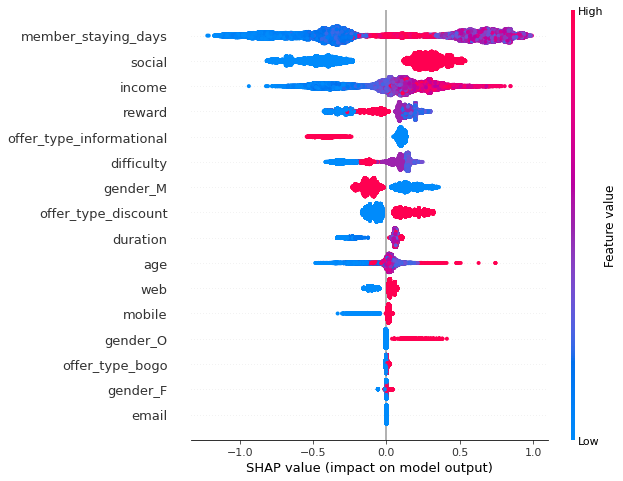

In [407]:
explainer = shap.TreeExplainer(gbm_default)
shap_values = explainer.shap_values(x_train,check_additivity=False)

shap.summary_plot(shap_values, x_train)